In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

!pip install yfinance
# Importing Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
def stock_data(stock, start_date, end_date):
    tickerSymbol = stock
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
    return tickerDf

df = stock_data("AAPL", "2014-06-08", "2025-06-08")
df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-09 00:00:00-04:00,20.430442,20.690506,20.221069,20.650835,301660000,0.0,7.0
2014-06-10 00:00:00-04:00,20.877844,20.948370,20.622187,20.772055,251108000,0.0,0.0
2014-06-11 00:00:00-04:00,20.745600,20.884448,20.600141,20.686094,182724000,0.0,0.0
2014-06-12 00:00:00-04:00,20.725768,20.743400,20.254127,20.340080,218996000,0.0,0.0
2014-06-13 00:00:00-04:00,20.320244,20.373140,20.029326,20.117483,218100000,0.0,0.0


In [4]:
df.shape

(2707, 7)

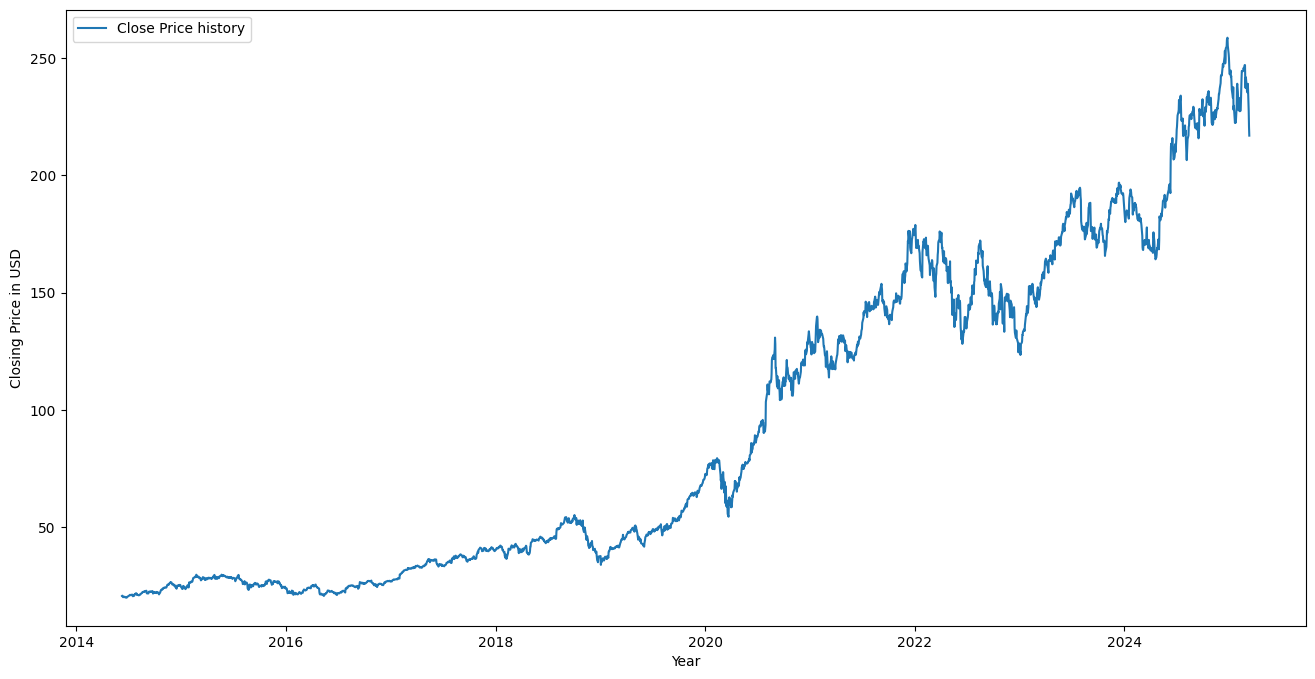

In [5]:
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()

In [6]:
df.dtypes
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2707.000000,2707.000000,2707.000000,2707.000000,2.707000e+03,2707.000000,2707.000000
mean,92.747123,93.736992,91.819141,92.827095,1.209054e+08,0.003012,0.004064
std,67.943317,68.657459,67.279880,68.014348,7.244544e+07,0.024317,0.154933
min,19.881657,19.989650,19.758238,19.897085,2.323470e+07,0.000000,0.000000
25%,30.956624,31.230711,30.892748,31.161027,7.129440e+07,0.000000,0.000000
50%,57.332511,58.170098,56.695275,57.064594,1.027672e+08,0.000000,0.000000
75%,150.514966,152.466937,148.710636,150.733391,1.498150e+08,0.000000,0.000000
max,257.906429,259.814335,257.347047,258.735504,7.593852e+08,0.250000,7.000000


In [7]:
df.reset_index(level="Date", inplace=True)
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [8]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]

df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()

,Close
Date,
2014-06-09 00:00:00-04:00,20.650835
2014-06-10 00:00:00-04:00,20.772055
2014-06-11 00:00:00-04:00,20.686094
2014-06-12 00:00:00-04:00,20.34008
2014-06-13 00:00:00-04:00,20.117483


In [9]:
data = df1.values
train = data[0:1750, :]
test = data[1750:, :]

print(train.shape)
print(test.shape)

(1750, 1)
(957, 1)


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
x_train, y_train = [], []
window = 60

for i in range(window, len(train)):
    x_train.append(scaled_data[i-window:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose=2)

Epoch 1/2
27/27 - 6s - 224ms/step - loss: 0.0043
Epoch 2/2
27/27 - 2s - 60ms/step - loss: 3.1092e-04


In [15]:
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [16]:
mse = math.sqrt(mean_squared_error(test, closing_price))
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 9.08163053551474


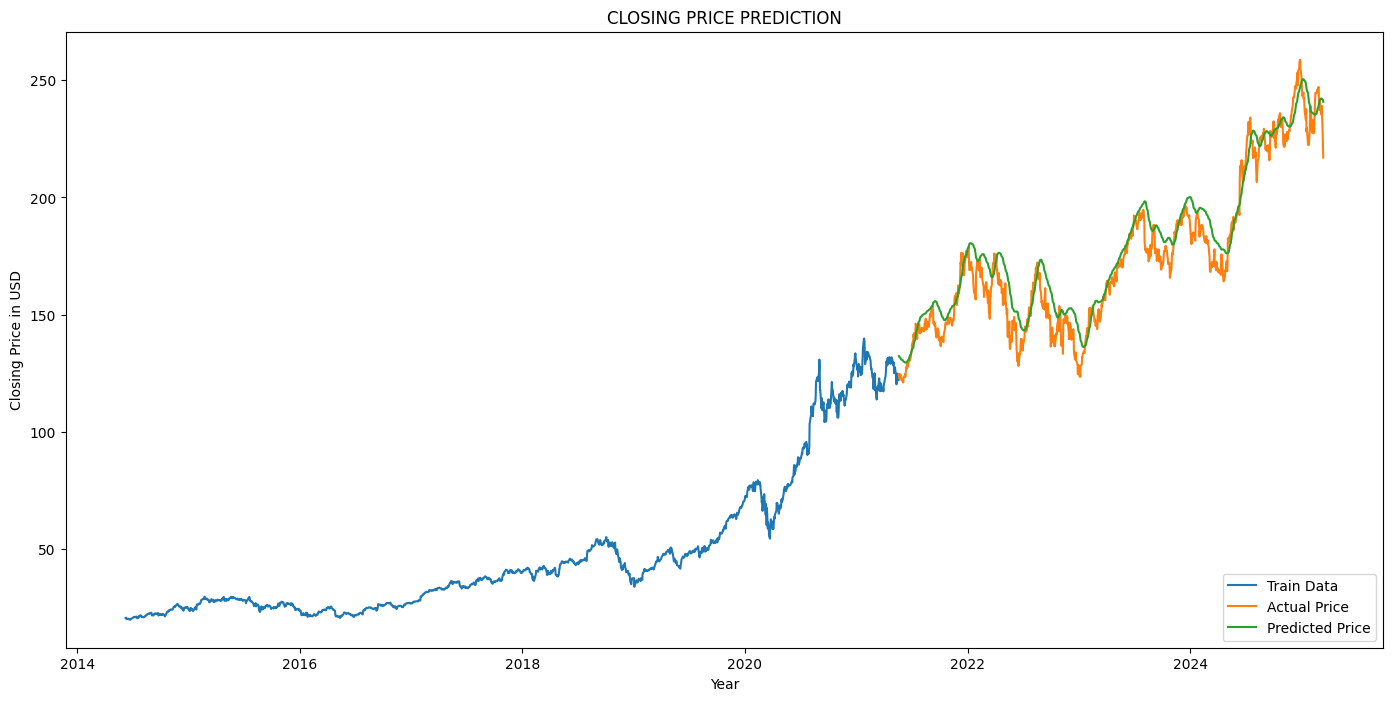

In [17]:
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.title("CLOSING PRICE PREDICTION")
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc="lower right")
plt.show()